In [17]:
# Adrian Marinovich
# Springboard - Data Science Career Track 
# Smiles dataset
# Visualize and explore

#### First we load in the data from the previously saved datasets in the Data Wrangling notebook, split them into train and test sets, and then scale them.

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

# From smiles_data_wrangling180925github:

import boto3
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import pandas as pd
import re
import shutil

s3 = boto3.resource('s3')
client = boto3.client('s3')
resource = boto3.resource('s3')

# The S3 buckets already created, hold:
#   All 13233 LFWcrop images in adriatic13s1, obtained from:
#     http://conradsanderson.id.au/lfwcrop/
#   The smile and non-smile lists in adriatic13s2, obtained from:
#     https://data.mendeley.com/datasets/yz4v8tb3tp/5

# Additional, from smiles_eda_viz_forest:

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier

# Make output stable
np.random.seed(42)

# Setup plots
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
# Load in X (features) image pixels dataset
X = np.load('smile/smile_X.npy')
X.shape

(1203, 4096)

In [3]:
# Load in y (target) dataset
y = np.load('smile/smile_y.npy')
y.shape

(1203, 1)

In [4]:
# Create function to view images from pixel dataset
def plot_face(data):
    image = data.reshape(64, 64)
    plt.imshow(image, cmap = matplotlib.cm.gray,
               interpolation="nearest")
    plt.axis("off")

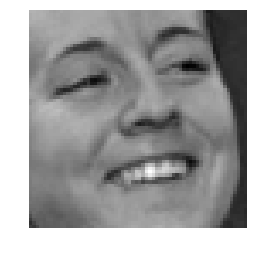

In [11]:
# Use this function to view image
plot_face(X[64])

In [8]:
# View the target value for an image
#  (1 is smile, 0 is no smile)
y[64]

array([1])

In [9]:
# Set a variable on one image
a_face = X[64]

In [12]:
# Create function to tile multiple images together
#  (taken from previous data wrangling notebook)

def plot_faces(instances, images_per_row=10, **options):
    size = 64
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.gray, **options)
    plt.axis("off")

In [13]:
# To remove possible index-specific biases embedded in the data,
#  shuffle the index for both X and y datasets
shuffle_index = np.random.permutation(1203)
X, y = X[shuffle_index], y[shuffle_index]

In [15]:
# Split dataset into train and test datasets,
#  with 1000 images in the train dataset, and 203 
#  images in the test dataset
y_train = y[:1000]
y_test = y[1000:]
X_train = X[:1000]
X_test = X[1000:]

In [16]:
# Scale the features data

#scaler = MinMaxScaler()
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

### From here, we will start with machine learning approaches to classify the images into smile or non-smile. We begin with a decision tree classifier. 

#### We compute two different decision trees, to compare the Gini vs. the entropy impurity criteria.

In [105]:
### Decision tree, gini: fit
gtree_clf = DecisionTreeClassifier(max_depth=4000, random_state=33)
gtree_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4000,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=33,
            splitter='best')

In [106]:
# Decision tree, gini: predict
gtree_labels_pred = gtree_clf.predict(X_test_scaled)
accuracy_score(y_test, gtree_labels_pred)

0.7783251231527094

In [107]:
# Decision tree, entropy: fit
etree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=4000, random_state=33)
etree_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4000,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=33,
            splitter='best')

In [108]:
# Decision tree, entropy: predict
etree_labels_pred = etree_clf.predict(X_test_scaled)
accuracy_score(y_test, etree_labels_pred)

0.8029556650246306

Plot the pixels according to their importance as features in the decision trees:

In [101]:
# (adapted from: https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb)
def plot_feat_imp(data):
    image = data.reshape(64, 64)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

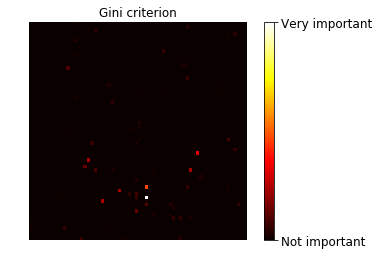

In [109]:
plot_feat_imp(gtree_clf.feature_importances_)

cbar = plt.colorbar(ticks=[gtree_clf.feature_importances_.min(), gtree_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.title('Gini criterion')
plt.show()

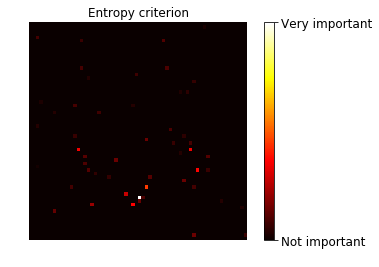

In [110]:
plot_feat_imp(etree_clf.feature_importances_)

cbar = plt.colorbar(ticks=[etree_clf.feature_importances_.min(), etree_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.title('Entropy criterion')
plt.show()

For both criteria, note that the important pixels seem to cluster in the mouth and cheeks regions, which is not surprising for a smile classifier. The entropy criterion seems to work a little bit better, however, and also appears to have a slightly more diffuse feature importance plot across the pixel map. 

#### We continue on to a random forest classifier using the entropy criterion, and again plot the pixel map colored by feature importance.

In [124]:
rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=33)
rf_clf.fit(X_train_scaled, np.ravel(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=33, verbose=0, warm_start=False)

In [127]:
rf_pred = rf_clf.predict(X_test_scaled)
accuracy_score(y_test, rf_pred)

0.9064039408866995

(Note that the BaggingClassifier approach was less accurate the RandomForestClassifier method (86% vs 91%), took longer to run, and did not output feature importances.)

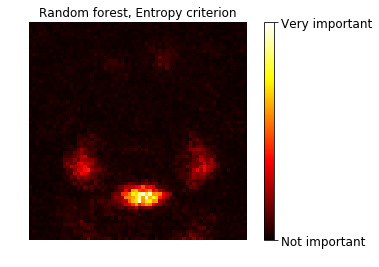

In [121]:
plot_feat_imp(rf_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rf_clf.feature_importances_.min(), rf_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.title('Random forest, Entropy criterion')
plt.show()

With random forest, now we can see a clearer importance clustering in the mouth and cheek regions, as well as fainter clusters in the forehead and neck regions.

#### We now plot the test faces on a contingency table to get more clues about true/false positives/negatives based on what we already know about the important pixels from above.

In [147]:
true_pos = (np.ravel(y_test) == 1) & (rf_pred == 1)
fals_neg = (np.ravel(y_test) == 1) & (rf_pred == 0)
fals_pos = (np.ravel(y_test) == 0) & (rf_pred == 1)
true_neg = (np.ravel(y_test) == 0) & (rf_pred == 0)

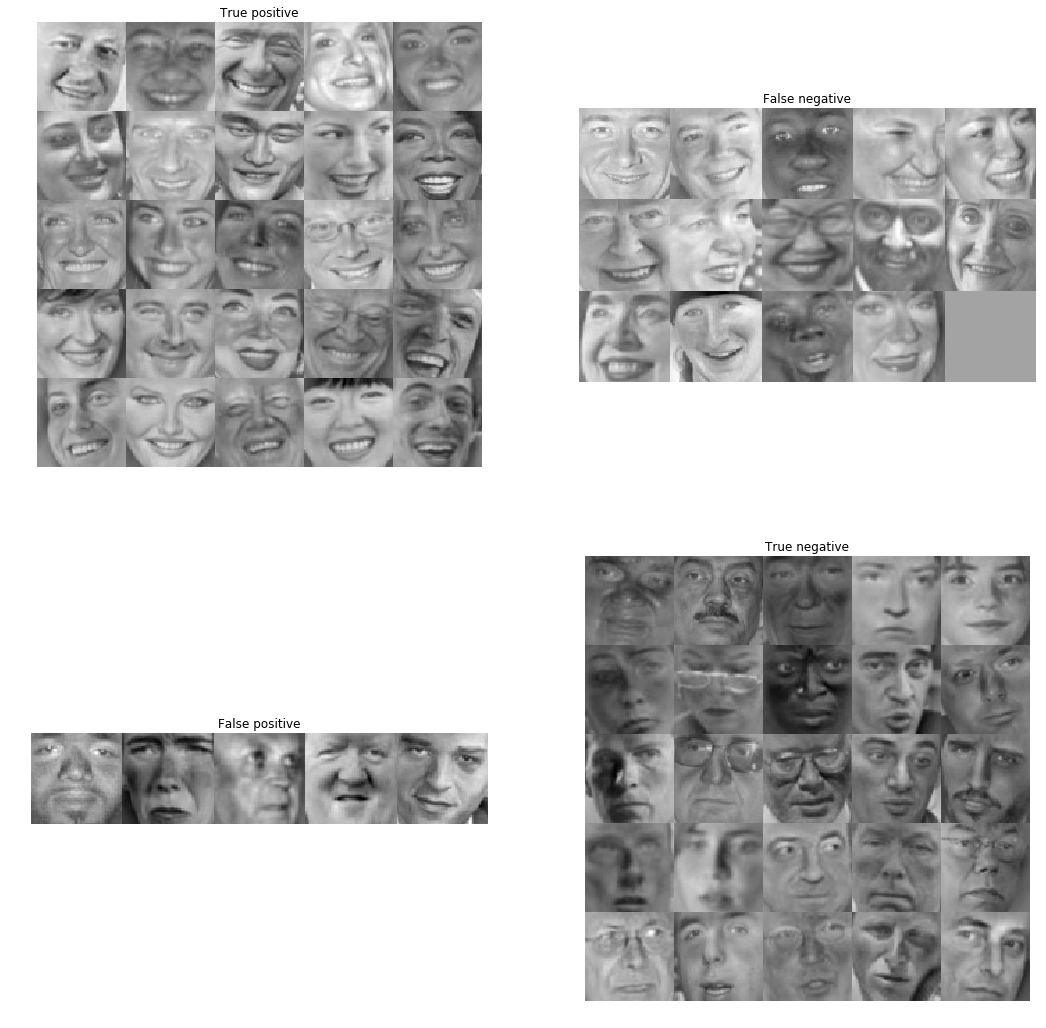

In [149]:
# individual error review
#  left column was classified as smile
#  right column was classified as no smile

X_aa = X_test_scaled[true_pos]
X_ab = X_test_scaled[fals_neg]
X_ba = X_test_scaled[fals_pos]
X_bb = X_test_scaled[true_neg]

plt.figure(figsize=(18,18))
plt.subplot(221); plot_faces(X_aa[:25], images_per_row=5)
plt.gca().set_title('True positive')
plt.subplot(222); plot_faces(X_ab[:25], images_per_row=5)
plt.gca().set_title('False negative')
plt.subplot(223); plot_faces(X_ba[:25], images_per_row=5)
plt.gca().set_title('False positive')
plt.subplot(224); plot_faces(X_bb[:25], images_per_row=5)
plt.gca().set_title('True negative')
plt.show()

While our machine learning exploration is only just beginning, the random forest approach and analysis of feature importances by pixel, coupled with plotting the test faces on a contingency table, indicates

In [150]:
np.save('smile/X_train.npy', X_train)
np.save('smile/X_test.npy', X_test)
np.save('smile/X_train_scaled.npy', X_train_scaled)
np.save('smile/X_test_scaled.npy', X_test_scaled)
np.save('smile/y_train.npy', y_train)
np.save('smile/y_test.npy', y_test)